In [1583]:
import numpy as np
import pandas as pd
pd.set_option('compute.use_numexpr', True)

import seaborn as sns
import matplotlib.pyplot as plt
from ipywidgets import widgets, interactive
import missingno as msno 


from sklearn import preprocessing
from sklearn.metrics import mean_squared_log_error, mean_squared_error
from sklearn.model_selection import KFold
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.inspection import PartialDependenceDisplay

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

import xgboost as xgb

import os
import glob
import pickle
import joblib

import warnings
warnings.filterwarnings('ignore')

In [1584]:
x_data = pd.read_csv('~/Downloads/Cars.csv')
x_data.head()

,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,torque,seats
0,Maruti Swift Dzire VDI,2014,450000,145500,Diesel,Individual,Manual,First Owner,23.4 kmpl,1248 CC,74 bhp,190Nm@ 2000rpm,5.0
1,Skoda Rapid 1.5 TDI Ambition,2014,370000,120000,Diesel,Individual,Manual,Second Owner,21.14 kmpl,1498 CC,103.52 bhp,250Nm@ 1500-2500rpm,5.0
2,Honda City 2017-2020 EXi,2006,158000,140000,Petrol,Individual,Manual,Third Owner,17.7 kmpl,1497 CC,78 bhp,"12.7@ 2,700(kgm@ rpm)",5.0
3,Hyundai i20 Sportz Diesel,2010,225000,127000,Diesel,Individual,Manual,First Owner,23.0 kmpl,1396 CC,90 bhp,22.4 kgm at 1750-2750rpm,5.0
4,Maruti Swift VXI BSIII,2007,130000,120000,Petrol,Individual,Manual,First Owner,16.1 kmpl,1298 CC,88.2 bhp,"11.5@ 4,500(kgm@ rpm)",5.0


In [1585]:
# x_data['owner']=x_data['owner'].astype('category')
x_data['seller_type'].value_counts()

seller_type
Individual          6766
Dealer              1126
Trustmark Dealer     236
Name: count, dtype: int64

**Tried to combine Dealer and Truestmaker Dealer as group**

In [1586]:
x_data['owner'].loc[x_data[(x_data['owner'] == 'Fourth & Above Owner') | (x_data['owner'] == 'Third Owner')].index] = 'others'

In [1587]:
#few operations
#remove the rows with CNG and Petrol because of diffenece in units
x_data.drop(x_data[(x_data['fuel'] == 'CNG') | (x_data['fuel'] == 'LPG')].index, inplace=True)
x_data['mileage']=x_data['mileage'].apply(lambda x: str(x).split()[0]).astype('float')
x_data['engine'] = x_data['engine'].apply(lambda x: str(x).split()[0]).astype('float')

#remove the torque
x_data.drop(columns = {'torque'}, inplace=True)
# remove the test drive owners
x_data.drop(x_data[x_data['owner']=='Test Drive Car'].index, inplace=True)
x_data['company'] = x_data['name'].apply(lambda x:  x.split()[0])

x_data['max_power']= x_data['max_power'].apply(lambda x: str(x).split()[0])
x_data['max_power'] = x_data['max_power'].replace('bhp', np.NAN).astype('float')

<Axes: xlabel='count', ylabel='name'>

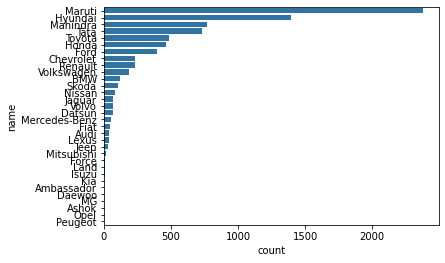

In [1588]:
#the number of companies car sold in total 
#this could be a feature to explain the future trajectory in the data
c_per_company =x_data['name'].apply(lambda x:x.split()[0]).value_counts()
sns.barplot(data = c_per_company.to_frame().reset_index(), x = 'count', y = 'name')

**Number of indivisual cars sold by the companies, though this is just and Explaination of Data might not condiser as feature**

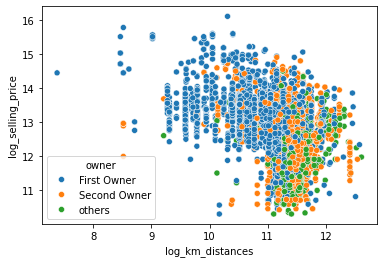

In [1589]:
x_data['km_distances']=x_data.groupby(['company','year','owner'])['km_driven'].transform(lambda x:  x.mean())

x_data['log_selling_price'] = x_data['selling_price'].transform('log')
x_data['log_km_distances'] = x_data['km_distances'].transform('log')
sns.scatterplot(data = x_data, x = 'log_km_distances', y = 'log_selling_price', hue="owner")

x_data.drop(columns = {'log_selling_price', 'log_km_distances'}, inplace=True)
#(np.log(x_data['selling_price']), np.log(x_data['km_distances']), hue='owner')

**As the more the car is driven, the lesser the price**

In [1590]:
#the specific company is almost null
x_data.drop(6730, inplace=True)

**Droping the row 6730 as it is almost misisng**

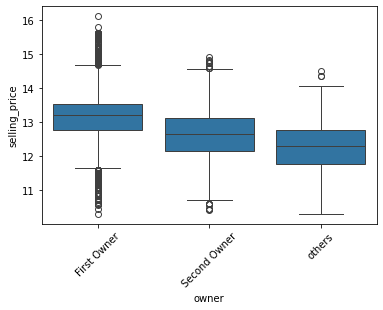

In [1591]:
ax=sns.boxplot(data = x_data, x = 'owner', y = x_data['selling_price'].transform('log'))
v=ax.set_xticklabels(ax.get_xticklabels(),rotation=45)

<span style = 'color:black'>**The First Owner has the considerable effect on the selling price owners with lesser driven and are from specific category of owner has the effect.**</span>

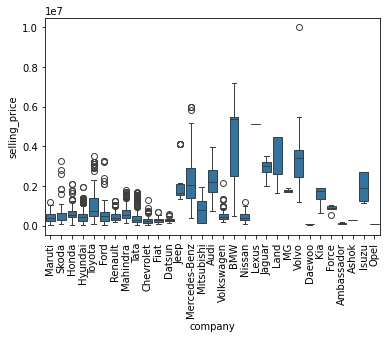

In [1592]:
ax=sns.boxplot(data = x_data,x = 'company', y = 'selling_price')
v=ax.set_xticklabels(ax.get_xticklabels(),rotation=90)

<Axes: xlabel='company', ylabel='year'>

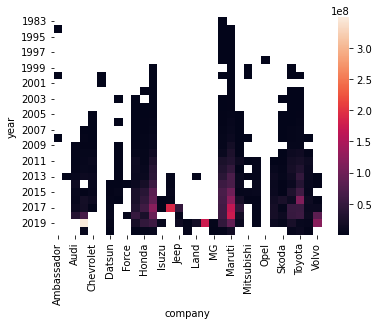

In [1593]:
b = x_data[['company', 'year', 'selling_price']].groupby(['company', 'year'])['selling_price'].apply(lambda x: x.sum())
b=b.reset_index()
sns.heatmap(b.pivot(columns = 'company', index = 'year', values = 'selling_price'))
#for example the maruti company have less selling price in 1983 than in 2020 but at the same time maruti have shown in the number of selling price

**Maruti has very less variation in selling price, yet is the most sold car accross the year, so the selling of maruti car is constant because of the range of price is not varying with the given data. At the same time BMW has the sqwness in bounding box feature sample is very less**

In [1594]:
#average sale of the company per year 
r=x_data.groupby(['company', 'year'])['name'].apply(lambda x:x.count()).reset_index()

r.set_index('year', inplace=True)
#r[r['company'] == 'Maruti']['name'].plot()
#x_data['company'].unique().shape
company_name = []
n_ = r['company'].value_counts().reset_index()
for k,i in n_.iterrows():
    if i['count'] > 6:
        company_name.append(i['company'])
Company_name = widgets.Dropdown(options= company_name, value=None, description='Company Name:')
def vol_plt(Company_name):
    df2 = r.copy()
    df2 = df2[df2.company == Company_name]
    if len(df2) > 0:
        #pv_df =x.pivot(index='time_id', columns='stock_id', values='target')
        df2.plot()
        plt.show()

interactive(vol_plt,Company_name=Company_name)

interactive(children=(Dropdown(description='Company Name:', options=('Maruti', 'Mahindra', 'Hyundai', 'Tata', …

**pre company car soled select the drop box**

In [1595]:
r = x_data[(x_data['company'] == 'Maruti') & (x_data['year'] == 2014)]
r[['company', 'name', 'year', 'selling_price']].groupby(['name', 'year'])['selling_price'].apply(lambda x: x.sum())

name                                     year
Maruti A-Star Vxi                        2014      250000
Maruti Alto 800 Base                     2014      185000
Maruti Alto 800 LX                       2014      196000
Maruti Alto 800 LXI                      2014     2682999
Maruti Alto 800 LXI Anniversary Edition  2014      240000
Maruti Alto 800 VXI                      2014      955998
Maruti Alto K10 2010-2014 VXI            2014      719998
Maruti Alto K10 LXI                      2014      469999
Maruti Alto K10 VXI                      2014     1704999
Maruti Alto LXi                          2014      110000
Maruti Celerio LXI                       2014      600000
Maruti Celerio VXI                       2014      320000
Maruti Celerio VXI AT                    2014      325000
Maruti Celerio ZXI                       2014     1095000
Maruti Celerio ZXI Optional              2014      415000
Maruti Ciaz VDi Plus                     2014      459999
Maruti Ciaz ZDi           

In [1596]:
#log transfrom of training data
# x_data['selling_price'] = x_data['selling_price'].transform('log')

In [1597]:
lb= OrdinalEncoder()
t = lb.fit(x_data['transmission'].values.reshape(-1,1))
# with open('transmission.pickle', 'wb') as f:
#     pickle.dump(t, f)

In [1598]:
lb= OneHotEncoder()
f = lb.fit(x_data['fuel'].values.reshape(-1, 1))
# with open('fuel.pickle', 'wb') as f_:
#     pickle.dump(f, f_)

In [1599]:
lb= OrdinalEncoder()
o = lb.fit(x_data['company'].values.reshape(-1,1))
# with open('company.pickle', 'wb') as f:
#     pickle.dump(o, f)

In [1600]:
lb = OneHotEncoder()
b = lb.fit(x_data['owner'].values.reshape(-1, 1))
# with open('owner.pickle', 'wb') as f:
#     pickle.dump(b, f)

In [1601]:
lb = OrdinalEncoder()
b_ = lb.fit(x_data['owner'].values.reshape(-1, 1))
# with open('owner_ordinal.pickle', 'wb') as f:
#     pickle.dump(b, f)

**Few embedding done**

In [1602]:
#split the training and testing data before hand
x_data['index'] = x_data.index
# test = x_data.loc[round(x_data.shape[0]-x_data.shape[0]*0.20):x_data.shape[0]]
# train = x_data.loc[0:round(x_data.shape[0]-x_data.shape[0]*0.20) - 1]
state = round(np.random.uniform(100))
train, test, y_train, y_test = train_test_split(x_data, x_data['selling_price'], test_size=0.20, random_state= state)

**Early test train split at unifrom random**

In [1603]:
train.shape, y_train.shape

((6421, 15), (6421,))

In [1604]:
number_sold = train.groupby(['company'])['name'].apply(lambda  x: x.value_counts()).to_frame().reset_index().rename(columns = {'level_1':'name', 'name':'number_sold'})
train = pd.merge(number_sold, train, on = ['company', 'name'], how = 'right')

number_sold = test.groupby(['company'])['name'].apply(lambda  x: x.value_counts()).to_frame().reset_index().rename(columns = {'level_1':'name', 'name':'number_sold'})
test = pd.merge(number_sold, test, on = ['company', 'name'], how = 'right')


**Let us see the impact of numbers of vayring car sold each year by the each company**

<Axes: title={'center': 'Maruti Ritz VDi'}, xlabel='year'>

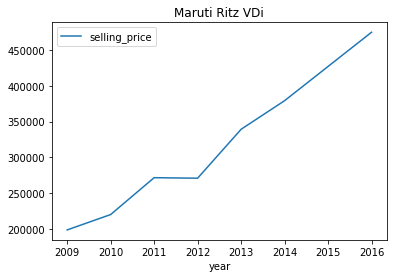

In [1605]:
#because of short of time could make interactive plots
r2 = train.groupby(['company', 'name','year'])['selling_price'].apply(lambda x:x.mean()).reset_index()
r2[(r2['company'] == 'Maruti') & (r2['name'] == 'Maruti Ritz VDi')][['year','selling_price']].set_index('year').plot(title = 'Maruti Ritz VDi')

<Axes: >

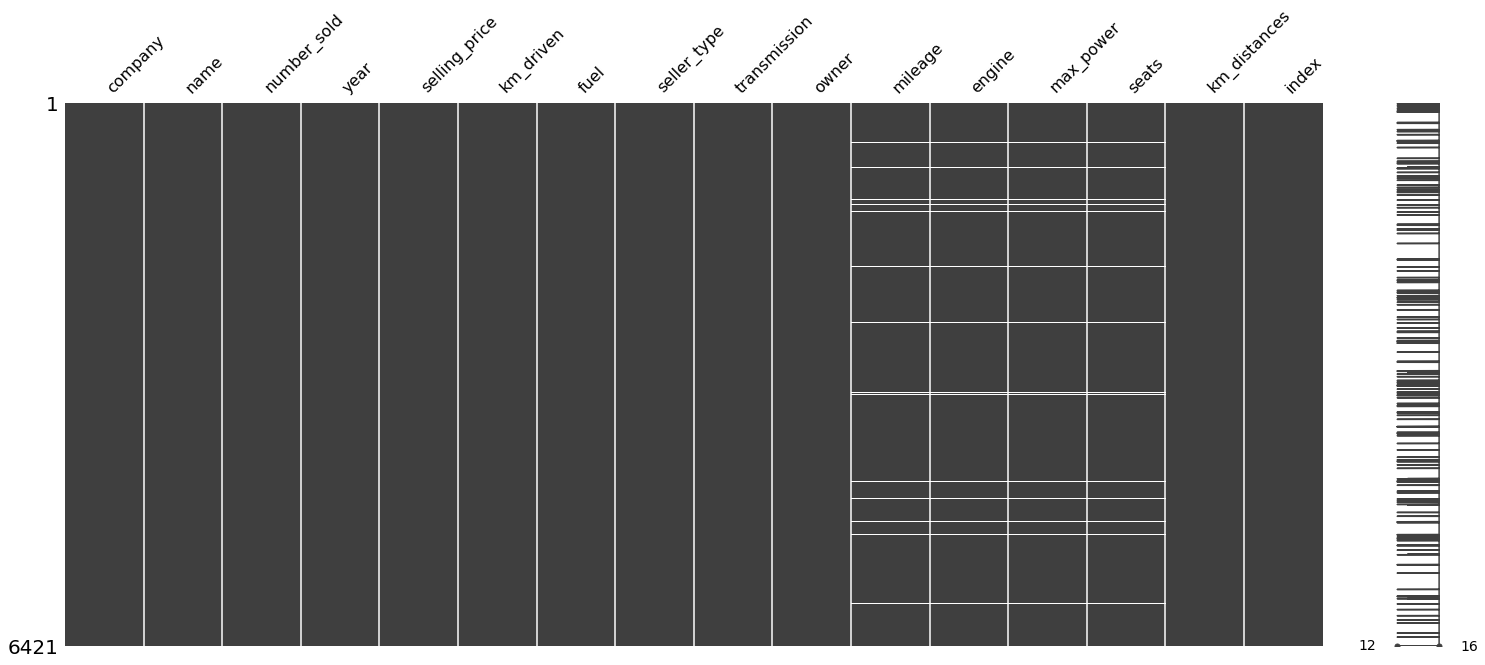

In [1606]:
msno.matrix(train)

**The missingness looks like not missing at random. The missing data might have some pattren by some covariates 
or eaxtral causal impact, which out of the scope of this notebook, we did some basic imputation**

In [1607]:
def imputation_d(x):
    if x.shape[0] > 0:            
        x['engine']=x['engine'].apply(lambda x: str(x).split()[0]).astype('float')
        x['index'] = x.index
        r=x.groupby('company')['engine'].apply(lambda x: x.fillna(x.median()))
        x.set_index(['company', 'index'], inplace=True)
        x['engine'] = r
        x.reset_index(inplace=True)
        
        #even though the full distribution is centered to mean but so mean is close to median , 
        #but here filling up each distribution with median as per the company
        # filling missing values for milage
        x['index'] = x.index
        r = x.groupby('company')['mileage'].apply(lambda x: x.fillna(x.mean()))
        x.set_index(['company', 'index'], inplace=True)
        x['mileage'] = r
        x.reset_index(inplace=True)
        
        x['binned_engine']=pd.cut(x['engine'], [1, 1000, 1500, 1800, x['engine'].max()], labels = list(range(1,5))[::-1])
        #drop all the na columns
        x.drop(x[x['binned_engine'].isna()].index, inplace=True)
        x['binned_engine'] = x.binned_engine.astype('int')
        
        #the distribution of max_power is not mean centered as whole so each group will be assumed (because the data is MNAR) to have median of each 
        #maxpower engine produced by companies
        x['index'] = x.index
        r = x.groupby('company')['max_power'].apply(lambda x: x.fillna(x.mean()))
        x.set_index(['company', 'index'], inplace=True)
        x['max_power'] = r
        x.reset_index(inplace=True)
        
        # seat is not the ordinal data if that so enconding required
        # filling na values by filling in with a company not sure if this make sense 
        ix=x[x['seats'].isna()].index
        for i in ix:
            name =x.loc[i]['company']
            min_seats = x[x['company'] == name]['seats'].min()
            max_seats = x[x['company'] == name]['seats'].max()
            if not pd.isna(min_seats):
                x['seats'].loc[i]=round(max_seats/min_seats) 
        return x

In [1608]:
train = imputation_d(train)
test = imputation_d(test)

<Axes: xlabel='binned_engine', ylabel='count'>

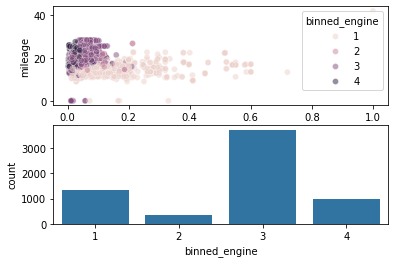

In [1609]:
#binning
fig, ax=plt.subplots(2)
sns.scatterplot(ax = ax[0],data = train , x ='selling_price', y= 'mileage', hue = 'binned_engine', alpha=0.5)
bin_counts = train['binned_engine'].value_counts().reset_index()
sns.barplot(ax = ax[1], data = bin_counts, x= 'binned_engine', y = 'count')


**Engine can be considered as ordinal data, because the better the engine by cc is the higher the price, we tries to perform ordinal linear encoding by binning the ranges of engines per cc**

In [1579]:

def features(x, encoding='one_hot', phase='Traning', required_unscale = True):
    #x['avg_yearly'] = x.groupby(['company','year'])['selling_price'].transform('mean')
    x['co_cc']=x.groupby(['company'])['year'].transform(lambda x: sum(x-x.min())).astype('float')
    x['_num_sales'] = x.groupby(['company', 'year'])['name'].transform('count')
    r=x.groupby(['company', 'year'])['name'].apply(lambda x:x.count()).reset_index() 
        
    x['transmission'] = pd.Series(t.transform(x['transmission'].values.reshape(-1,1)).astype('int').flatten())
   
    m = f.transform(np.array(x['fuel']).reshape(-1,1)).toarray()
    x[['Diesel','petrol']] = pd.DataFrame.from_records(m , columns = x['fuel'].unique())
    
    if encoding == 'one_hot':
        m = b.transform(np.array(x['owner']).reshape(-1,1)).toarray()
        x[['firstowner', 'secondowner', 'others']] = pd.DataFrame.from_records(m, columns = x['owner'].unique())
    elif encoding == 'oridinal':
        x['_owner_encoded'] = pd.Series(b_.transform(x['owner'].values.reshape(-1,1)).astype('int').flatten())
#     x['_owner_encoded']=x.groupby('company')['_owner_encoded'].transform(lambda x: x/x.max())
    
    x['_company'] = o.transform(x['company'].values.reshape(-1,1)).astype('int')

    r = x.groupby(['company', 'year'])['seats'].value_counts()
    x.set_index(['company', 'year', 'seats'], inplace = True)
    x['_seats_in_year'] = r
    x.reset_index(inplace=True)
    
    r = x.groupby(['company', 'seller_type'])['selling_price'].apply(np.mean)
    x.set_index(['company', 'seller_type'], inplace=True)
    x['avg_sellertype'] = r
    x.reset_index(inplace=True)
    
###scaling features
    x['km_distances']=x.groupby(['company', 'year','owner'])['km_driven'].transform(lambda x: x.mean())
    x['km_distances'] = x['km_distances'].transform('log')
    
    global s_, s_p
    fs = ['km_distances', 'avg_sellertype', 'selling_price']
    if phase =='Training':
        s = StandardScaler()
        selling_price = x['selling_price']
        s_ = s.fit(x[fs].values)
        x[fs] = s_.transform(x[fs].values)
        if required_unscale:
            s_1 = StandardScaler()
            s_p = s_1.fit(selling_price.values.reshape(-1, 1))
            return x, selling_price,s_p
    elif phase == 'Testing':
            selling_price = x['selling_price']
            x[fs] = s_.transform(x[fs].values)
            if required_unscale:
                return x, selling_price,s_p
    #per year sold cars 
    
    return x
    

**Basic Feature Engineering ,**
* the older year model have lesser price than recent model accroding the data
* Number of Sales by the company
* One hot encoding of other features
* Km distances the range as it travled, more or less
* Few standard scaling
**Tried more features but have impact on predictability**

In [1610]:
train, unscaled_train, scaler_train  = features(train, phase='Training')
test, unscaled_test,scaler_test = features(test, phase='Testing')

In [1616]:
#train.to_csv('~/train.csv')
pickle.dump(scaler_train ,open('scaler_train', 'wb'))

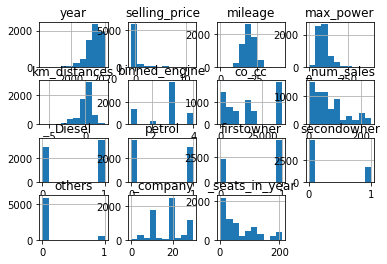

In [1611]:
#data cleaning
drop_columns = ['engine','seats','owner',
                'seller_type','number_sold','name',
                'index', 'company', 'fuel', 'transmission', 'avg_sellertype', 'km_driven']
train.drop(columns = drop_columns, inplace=True)
test.drop(columns = drop_columns,inplace=True)
ax=train.hist()

In [1550]:
#train.to_csv('~/clean_data.csv')

In [1612]:
x_target = train['selling_price']
y_target = test['selling_price']
train.drop(columns = 'selling_price', inplace=True)
test.drop(columns ='selling_price', inplace=True)

In [1613]:
def fit_and_score(estimator, X_train, X_test, y_train, y_test):
    """Fit the estimator on the train set and score it on both sets"""
    estimator.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=True)
    
    train_score = estimator.score(X_train, y_train)
    test_score = estimator.score(X_test, y_test)

    return estimator, train_score, test_score


cv = KFold(n_splits=8, shuffle=True, random_state=6)
#fix these parameter
params = {'max_depth':6, 'eta':0.01,'eval-metric':'rmse',
          'colsample_bytree':0.9,'enable_categorical':True, 'lambda':0.1}
evallist = [(train, 'train'), (test, 'eval')]
reg = xgb.XGBRegressor(early_stopping_rounds=3,  **params)

results = {'train_res':[], 'test_res':[]}

for train_index, test_index in cv.split(train, x_target):
    X_train = train.loc[train_index]
    X_test = train.loc[test_index]
    y_train = x_target.loc[train_index]
    y_test = x_target.loc[test_index]
    est, train_score, test_score = fit_and_score(
        reg, X_train, X_test, y_train, y_test
    )
    results['train_res'].append(train_score)
    results['test_res'].append(test_score)

    
    
#write the testing functions
#perform testing 

[0]	validation_0-rmse:0.89779
[1]	validation_0-rmse:0.88959
[2]	validation_0-rmse:0.88150
[3]	validation_0-rmse:0.87348
[4]	validation_0-rmse:0.86551
[5]	validation_0-rmse:0.85771
[6]	validation_0-rmse:0.85018
[7]	validation_0-rmse:0.84260
[8]	validation_0-rmse:0.83508
[9]	validation_0-rmse:0.82760
[10]	validation_0-rmse:0.82025
[11]	validation_0-rmse:0.81288
[12]	validation_0-rmse:0.80555
[13]	validation_0-rmse:0.79843
[14]	validation_0-rmse:0.79133
[15]	validation_0-rmse:0.78454
[16]	validation_0-rmse:0.77789
[17]	validation_0-rmse:0.77106
[18]	validation_0-rmse:0.76417
[19]	validation_0-rmse:0.75746
[20]	validation_0-rmse:0.75101
[21]	validation_0-rmse:0.74451
[22]	validation_0-rmse:0.73806
[23]	validation_0-rmse:0.73150
[24]	validation_0-rmse:0.72494
[25]	validation_0-rmse:0.71871
[26]	validation_0-rmse:0.71234
[27]	validation_0-rmse:0.70607
[28]	validation_0-rmse:0.70002
[29]	validation_0-rmse:0.69399
[30]	validation_0-rmse:0.68779
[31]	validation_0-rmse:0.68173
[32]	validation_0-

[66]	validation_0-rmse:0.64438
[67]	validation_0-rmse:0.63980
[68]	validation_0-rmse:0.63544
[69]	validation_0-rmse:0.63118
[70]	validation_0-rmse:0.62725
[71]	validation_0-rmse:0.62283
[72]	validation_0-rmse:0.61863
[73]	validation_0-rmse:0.61471
[74]	validation_0-rmse:0.61033
[75]	validation_0-rmse:0.60643
[76]	validation_0-rmse:0.60222
[77]	validation_0-rmse:0.59807
[78]	validation_0-rmse:0.59434
[79]	validation_0-rmse:0.59019
[80]	validation_0-rmse:0.58659
[81]	validation_0-rmse:0.58292
[82]	validation_0-rmse:0.57895
[83]	validation_0-rmse:0.57508
[84]	validation_0-rmse:0.57130
[85]	validation_0-rmse:0.56782
[86]	validation_0-rmse:0.56406
[87]	validation_0-rmse:0.56075
[88]	validation_0-rmse:0.55707
[89]	validation_0-rmse:0.55385
[90]	validation_0-rmse:0.55033
[91]	validation_0-rmse:0.54707
[92]	validation_0-rmse:0.54390
[93]	validation_0-rmse:0.54046
[94]	validation_0-rmse:0.53707
[95]	validation_0-rmse:0.53370
[96]	validation_0-rmse:0.53021
[97]	validation_0-rmse:0.52676
[98]	val

[32]	validation_0-rmse:0.74400
[33]	validation_0-rmse:0.73738
[34]	validation_0-rmse:0.73080
[35]	validation_0-rmse:0.72426
[36]	validation_0-rmse:0.71780
[37]	validation_0-rmse:0.71139
[38]	validation_0-rmse:0.70556
[39]	validation_0-rmse:0.69933
[40]	validation_0-rmse:0.69323
[41]	validation_0-rmse:0.68723
[42]	validation_0-rmse:0.68125
[43]	validation_0-rmse:0.67549
[44]	validation_0-rmse:0.66960
[45]	validation_0-rmse:0.66370
[46]	validation_0-rmse:0.65791
[47]	validation_0-rmse:0.65260
[48]	validation_0-rmse:0.64688
[49]	validation_0-rmse:0.64127
[50]	validation_0-rmse:0.63587
[51]	validation_0-rmse:0.63056
[52]	validation_0-rmse:0.62516
[53]	validation_0-rmse:0.61983
[54]	validation_0-rmse:0.61450
[55]	validation_0-rmse:0.60935
[56]	validation_0-rmse:0.60419
[57]	validation_0-rmse:0.59901
[58]	validation_0-rmse:0.59394
[59]	validation_0-rmse:0.58893
[60]	validation_0-rmse:0.58389
[61]	validation_0-rmse:0.57891
[62]	validation_0-rmse:0.57400
[63]	validation_0-rmse:0.56916
[64]	val

[97]	validation_0-rmse:0.39009
[98]	validation_0-rmse:0.38682
[99]	validation_0-rmse:0.38363


**The test data split is done uniformally but sometimes the ranodm states picks the extreme values, so the solution depends up twiking colsample_bytree** 

<Axes: xlabel='importance', ylabel='features'>

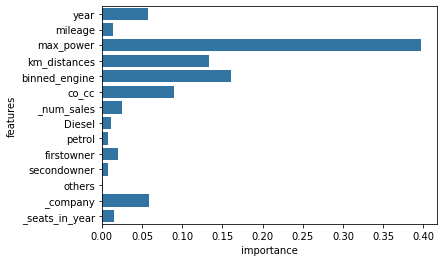

In [1614]:
#plt.bar(reg.feature_importances_,reg.feature_names_in_)
#increasing the subsamples with the gro
#wth of the tree reduces the dependence on time features

#higher number are given more importance so scalingis requires
fp = pd.DataFrame({'importance':reg.feature_importances_, 'features':reg.feature_names_in_})
sns.barplot(data = fp, x = 'importance', y = 'features')

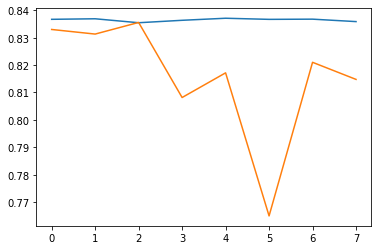

In [1532]:
plt.plot(results['train_res'])
plt.plot(results['test_res'])

In [1350]:
# test.to_csv('~/test.csv')

In [1640]:
pred_ = reg.predict(test)

In [1534]:
mean_squared_error(y_target,pred_)


#42187607721.344154
#41554360734.61742
#43874529730.4378
#42741272496.56432
#281228686473.33435
#286392329945.6325
#285980847040.8589
#286763526941.90283
#137272859152.24387
#272504534975.3524
#308501093300.2577 exp
#144429976274.1321 #without log #272437096508.803
#586392828625.6597 #with log without conversion
#111478616311.1431 #the best score
#128993068451.9105
#300212168798.217 #with log
#179612178237.39307


#317437509777.38947 after log transform
#0.6828444483371858 without log tranform


0.22013236336775294

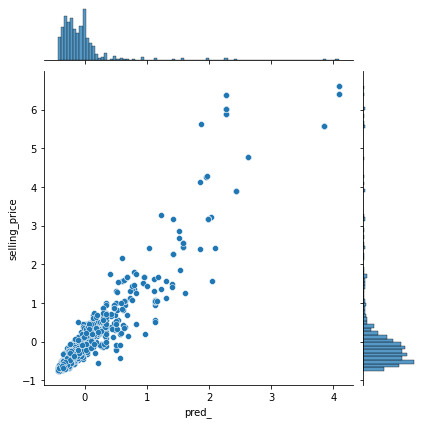

In [1535]:
data = pd.concat([pd.Series(pred_), 
                        y_target], axis = 1).rename(columns = {0:'pred_'})

sns.jointplot(data = data, x = 'pred_', y = 'selling_price')

#lot of deviation in the error rate 

In [1615]:
# pickle.dump(reg, open('/home/qb/xgb1', "wb"))

**The deviation the price, between 1 to 2 on e^6 scale has higer deviaion, that means the higher price will have higer uncertanity we can crontrol to extent**

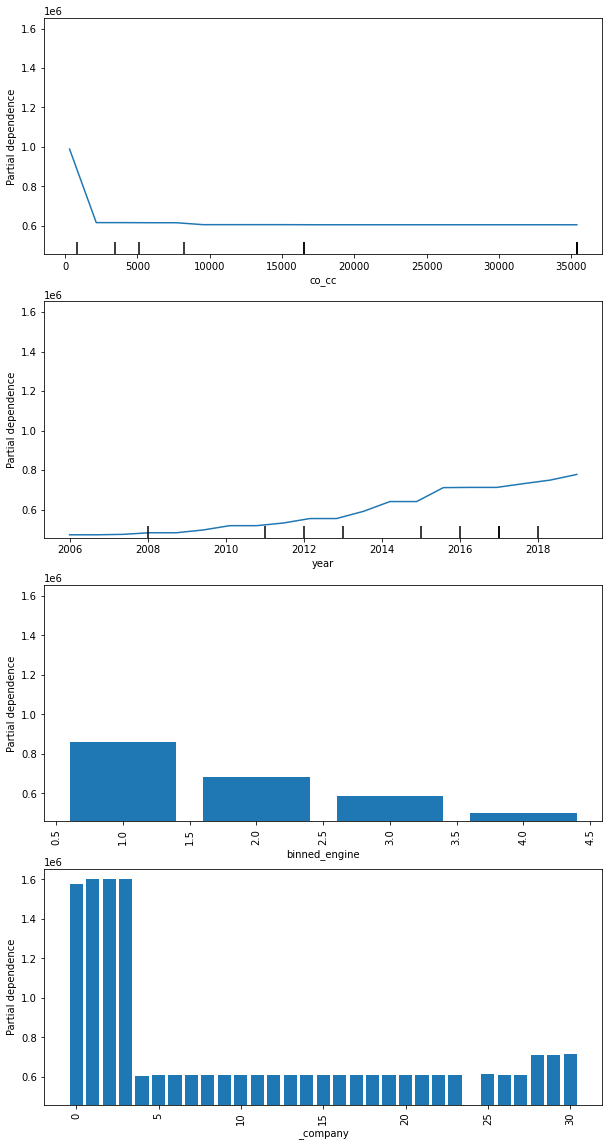

In [4067]:
fig , ax = plt.subplots(4, figsize = (10,20))
common_params = {
    "subsample": 50,
    "n_jobs": 2,
    "grid_resolution": 20,
    "random_state": 0,
}
features_info = {
    "features": ["co_cc","year", 'binned_engine','_company'],
    # type of partial dependence plot
    "kind": "average",
    "categorical_features": ['binned_engine','_company']}

display = PartialDependenceDisplay.from_estimator(
    reg,
    X_train,
    **features_info,
    ax=ax,
    **common_params,
)

#the owner encoded is 

**the model is depecting that the _company attribute is giving more preference to the companies with the lower price, Lower price will have less uncertainity**

<Axes: xlabel='year'>

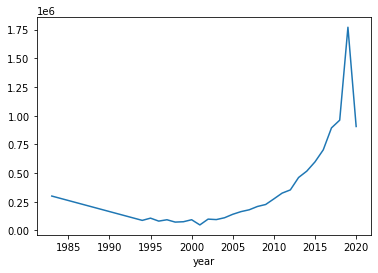

In [4068]:
x_data.groupby(['year'])['selling_price'].apply(lambda x: x.mean()).plot()

**Here we can see the results the model capture for year the latest year have hire the selling price on average**
**Let try Linear Regression model**

In [1617]:
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV


def fit_and_score(estimator, X_train, X_test, y_train, y_test):
    """Fit the estimator on the train set and score it on both sets"""
    estimator.fit(X_train, y_train)
    train_score = estimator.score(X_train, y_train)
    test_score = estimator.score(X_test, y_test)

    return estimator, train_score, test_score
cv = KFold(n_splits=10, shuffle=True, random_state=6)
lm_= RidgeCV(alphas = (0.1,0.2,0.6,5) , cv = cv)

trainscore = []
testscore = []
ests = []
for train_index, test_index in cv.split(train, x_target):
    X_train = train.loc[train_index]
    X_test = train.loc[test_index]
    y_train = x_target.loc[train_index]
    y_test = x_target.loc[test_index]
    est, train_score, test_score = fit_and_score(
        lm_, X_train, X_test, y_train, y_test
    )
    trainscore.append(train_score)
    testscore.append(test_score)
    ests.append(ests)

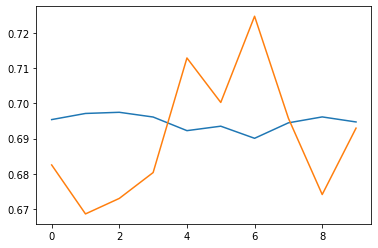

In [1618]:
plt.plot(trainscore)
plt.plot(testscore)

**Here Riged model have totally different variable between train and test set explaination**

In [1619]:
pred=lm_.predict(test)

In [1620]:
# y_hat = np.exp(grid.predict(test.fillna(0)))
# mean_squared_error(np.exp(y_target),np.exp(grid.predict(test.fillna(0))))
mean_squared_error(y_target , pred)

0.30078735807630697

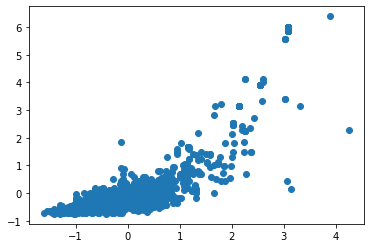

In [1621]:
plt.scatter(pred, y_target)

**The effect of the target is shown in predict , that means Rigid linear model is not able to handle exponentially growing selling price number** 

In [1622]:
log_x_target=np.log(unscaled_train)
log_y_target = np.log(unscaled_test)

# log_x_target = np.log(x_target + 1)
# log_y_target = np.log(y_target + 1)

In [1635]:
cv = KFold(n_splits=5, shuffle=True, random_state=24)
lm_= RidgeCV(alphas = (0.1,0.2,0.6,5) , cv = cv)
trainscore = []
testscore = []

for train_index, test_index in cv.split(train, log_x_target):
    X_train = train.loc[train_index]
    X_test = train.loc[test_index]
    y_train = log_x_target[train_index]
    y_test = log_x_target[test_index]
    est, train_score, test_score = fit_and_score(
        lm_, X_train, X_test, y_train, y_test
    )
    trainscore.append(train_score)
    testscore.append(test_score)    

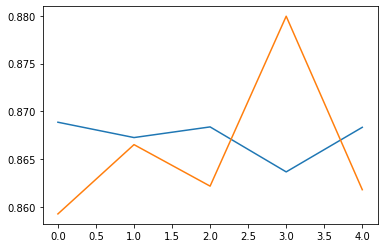

In [1636]:
plt.plot(trainscore)
plt.plot(testscore)

**on average at each random splits the validation set have more r^2 value than the training data, i.e allowing ridge regression to focus more on the bigger numbers**

In [1637]:
pred = lm_.predict(test)
mean_squared_error(log_y_target , pred)

0.09310878805363994

In [1644]:
#pickle.dump(lm_, open('/home/qb/lm_.pkl', "wb"))

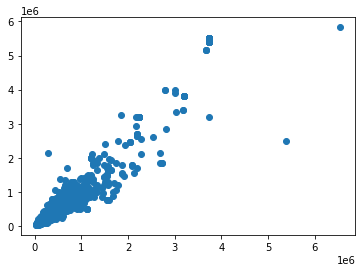

In [1638]:
plt.scatter(np.exp(pred), np.exp(log_y_target))

**post log transform model regularised to reduce variation up to some extent the relationship shows that the solution bend towards more variation**

In [1641]:
#blending solution mse of previous model
mean_squared_error(y_target ,pred_)

0.2104002761775767

In [1642]:
#control more over fitting and better results
r_=scaler_train.fit_transform(np.exp(pred).reshape(-1,1)).flatten()
mean_squared_error(y_target,pred_+0.04*scaler_train.fit_transform(np.exp(pred).reshape(-1,1)).flatten())

0.18238338421121092

**The blending rate is small because of the scaled target variables**

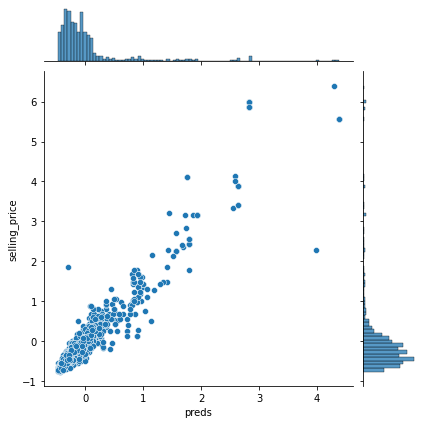

In [1643]:
#highly penalized data may over fit take uptil 0.2 , 0.9 is just to see the impact
data = pd.concat([y_target, 
                  pd.Series(pred_ +  0.04*r_)], axis = 1).rename(columns ={0:'preds'})

sns.jointplot(data =data, x = 'preds', y = 'selling_price')

**The higher L2 norm gives better uncertainity but can over fit here alphs is 1e6, there is littel deviation in the tail of error rate of predicted data**

In [1349]:
pickle.dump(lm_, open('lm.pkl', 'wb')) 

# <span style = color:blue>Explained feature behaviour and interesting features</span>
**Owner as a freature shows very interesting behavious, As an assumption the FirstOwner will sell the car at higher price than the owner with second ownership or third. Further The provided data does not have sufficent information for the model to understand this ordinal impact. So i tried to make owner as categorical feature. Still because of lack of infomration we cannot see the impact. Inorder reporduce the same let's train the model again.**

In [1310]:
train, test, y_train, y_test = train_test_split(x_data, x_data['selling_price'], test_size=0.20, random_state= 65)
train, unscaled_train, scaler_train  = features(train, phase='Training')
test, unscaled_test,scaler_test = features(test, phase='Testing')
drop_columns = ['engine','seats','owner','max_power',
                'seller_type','name',
                'index', 'company', 'fuel', 'transmission', 'Diesel','petrol','avg_sellertype', 'km_driven']
train.drop(columns = drop_columns, inplace=True)
test.drop(columns = drop_columns,inplace=True)
x_target = train['selling_price']
y_target = test['selling_price']
train.drop(columns = 'selling_price', inplace=True)
test.drop(columns ='selling_price', inplace=True)

In [1313]:
def fit_and_score(estimator, X_train, X_test, y_train, y_test):
    """Fit the estimator on the train set and score it on both sets"""
    estimator.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=True)
    
    train_score = estimator.score(X_train, y_train)
    test_score = estimator.score(X_test, y_test)

    return estimator, train_score, test_score


cv = KFold(n_splits=8, shuffle=True, random_state=6)
#fix these parameter
params = {'max_depth':6, 'eta':0.01,'eval-metric':'rmse',
          'colsample_bytree':0.9,'enable_categorical':True, 'lambda':0.1}
evallist = [(train, 'train'), (test, 'eval')]
reg = xgb.XGBRegressor(early_stopping_rounds=3,  **params)

results = {'train_res':[], 'test_res':[]}

for train_index, test_index in cv.split(train, unscaled_train):
    X_train = train.loc[train_index]
    X_test = train.loc[test_index]
    y_train = unscaled_train.loc[train_index]
    y_test = unscaled_train.loc[test_index]
    est, train_score, test_score = fit_and_score(
        reg, X_train, X_test, y_train, y_test
    )
    results['train_res'].append(train_score)
    results['test_res'].append(test_score)


[0]	validation_0-rmse:809643.67096
[1]	validation_0-rmse:802616.16903
[2]	validation_0-rmse:795668.37751
[3]	validation_0-rmse:788796.96000
[4]	validation_0-rmse:782015.59930
[5]	validation_0-rmse:775309.52682
[6]	validation_0-rmse:768807.61096
[7]	validation_0-rmse:762254.99078
[8]	validation_0-rmse:755809.83781
[9]	validation_0-rmse:749404.95976
[10]	validation_0-rmse:743033.63507
[11]	validation_0-rmse:736771.49959
[12]	validation_0-rmse:730623.74667
[13]	validation_0-rmse:724457.10093
[14]	validation_0-rmse:718504.51305
[15]	validation_0-rmse:712471.70457
[16]	validation_0-rmse:706545.31876
[17]	validation_0-rmse:700692.11191
[18]	validation_0-rmse:694952.76986
[19]	validation_0-rmse:689270.47364
[20]	validation_0-rmse:683534.90401
[21]	validation_0-rmse:678127.51383
[22]	validation_0-rmse:672589.08022
[23]	validation_0-rmse:667055.67112
[24]	validation_0-rmse:661651.98115
[25]	validation_0-rmse:656492.17015
[26]	validation_0-rmse:651051.89343
[27]	validation_0-rmse:645974.07475
[2

[29]	validation_0-rmse:498043.96801
[30]	validation_0-rmse:494168.83064
[31]	validation_0-rmse:490553.56657
[32]	validation_0-rmse:486697.92501
[33]	validation_0-rmse:483313.53096
[34]	validation_0-rmse:479906.47405
[35]	validation_0-rmse:476531.41053
[36]	validation_0-rmse:473100.46241
[37]	validation_0-rmse:469585.14085
[38]	validation_0-rmse:466251.65858
[39]	validation_0-rmse:463042.79606
[40]	validation_0-rmse:459907.68441
[41]	validation_0-rmse:456560.15539
[42]	validation_0-rmse:453459.07662
[43]	validation_0-rmse:450320.73150
[44]	validation_0-rmse:447148.26269
[45]	validation_0-rmse:444152.17287
[46]	validation_0-rmse:441130.86498
[47]	validation_0-rmse:438121.63554
[48]	validation_0-rmse:435061.29382
[49]	validation_0-rmse:432137.60597
[50]	validation_0-rmse:429217.97267
[51]	validation_0-rmse:426438.01160
[52]	validation_0-rmse:423527.93100
[53]	validation_0-rmse:420743.95623
[54]	validation_0-rmse:417909.52912
[55]	validation_0-rmse:415246.18630
[56]	validation_0-rmse:41245

[58]	validation_0-rmse:457666.08162
[59]	validation_0-rmse:454293.81129
[60]	validation_0-rmse:451185.86514
[61]	validation_0-rmse:447934.94855
[62]	validation_0-rmse:444718.42032
[63]	validation_0-rmse:441603.14179
[64]	validation_0-rmse:438651.28519
[65]	validation_0-rmse:435653.21271
[66]	validation_0-rmse:432654.37146
[67]	validation_0-rmse:429626.05042
[68]	validation_0-rmse:426521.46489
[69]	validation_0-rmse:423513.04292
[70]	validation_0-rmse:420802.01375
[71]	validation_0-rmse:417865.15409
[72]	validation_0-rmse:415025.52201
[73]	validation_0-rmse:412272.63342
[74]	validation_0-rmse:409545.02202
[75]	validation_0-rmse:406814.01923
[76]	validation_0-rmse:404010.62435
[77]	validation_0-rmse:401373.58225
[78]	validation_0-rmse:398785.53457
[79]	validation_0-rmse:396267.07612
[80]	validation_0-rmse:393761.29941
[81]	validation_0-rmse:391106.37813
[82]	validation_0-rmse:388711.41132
[83]	validation_0-rmse:386198.70337
[84]	validation_0-rmse:383881.41751
[85]	validation_0-rmse:38133

[87]	validation_0-rmse:490320.72723
[88]	validation_0-rmse:487914.92407
[89]	validation_0-rmse:485302.17238
[90]	validation_0-rmse:482634.22654
[91]	validation_0-rmse:480296.51544
[92]	validation_0-rmse:478078.14746
[93]	validation_0-rmse:475478.76672
[94]	validation_0-rmse:473337.44931
[95]	validation_0-rmse:470854.06476
[96]	validation_0-rmse:468750.59874
[97]	validation_0-rmse:466628.92678
[98]	validation_0-rmse:464259.00811
[99]	validation_0-rmse:462171.24690
[0]	validation_0-rmse:788733.53075
[1]	validation_0-rmse:781676.35656
[2]	validation_0-rmse:774790.92578
[3]	validation_0-rmse:767889.21137
[4]	validation_0-rmse:761066.94205
[5]	validation_0-rmse:754193.30658
[6]	validation_0-rmse:747505.16157
[7]	validation_0-rmse:740926.59628
[8]	validation_0-rmse:734388.00664
[9]	validation_0-rmse:727837.93522
[10]	validation_0-rmse:721554.96931
[11]	validation_0-rmse:715135.29451
[12]	validation_0-rmse:708993.64031
[13]	validation_0-rmse:702998.30636
[14]	validation_0-rmse:696863.99622
[1

<Axes: xlabel='importance', ylabel='features'>

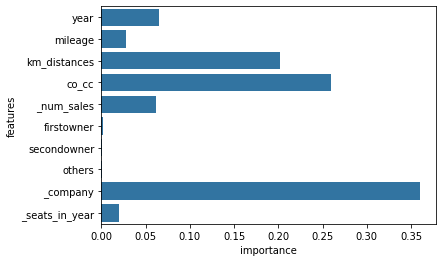

In [1314]:
fp = pd.DataFrame({'importance':reg.feature_importances_, 'features':reg.feature_names_in_})
sns.barplot(data = fp, x = 'importance', y = 'features')

**here we can see the model is not able to recognize the impact of owner variable**

<Axes: >

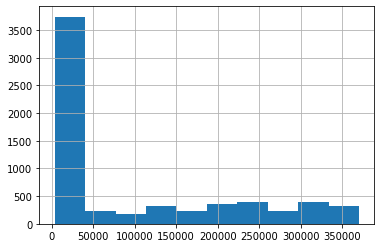

In [1333]:
import copy
t_copy=copy.deepcopy(unscaled_train)
r=t_copy[t_copy >t_copy.quantile(0.4)]*0.01
t_copy[r.index] = r
t_copy.hist()

**penalize the target**

In [1334]:
def fit_and_score(estimator, X_train, X_test, y_train, y_test):
    """Fit the estimator on the train set and score it on both sets"""
    estimator.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=True)
    
    train_score = estimator.score(X_train, y_train)
    test_score = estimator.score(X_test, y_test)

    return estimator, train_score, test_score


cv = KFold(n_splits=8, shuffle=True, random_state=6)
#fix these parameter
params = {'max_depth':6, 'eta':0.01,'eval-metric':'rmse',
          'colsample_bytree':1,'enable_categorical':True, 'lambda':0.1}
evallist = [(train, 'train'), (test, 'eval')]
reg = xgb.XGBRegressor(early_stopping_rounds=3,  **params)

results = {'train_res':[], 'test_res':[]}

for train_index, test_index in cv.split(train, t_copy):
    X_train = train.loc[train_index]
    X_test = train.loc[test_index]
    y_train = t_copy.loc[train_index]
    y_test = t_copy.loc[test_index]
    est, train_score, test_score = fit_and_score(
        reg, X_train, X_test, y_train, y_test
    )
    results['train_res'].append(train_score)
    results['test_res'].append(test_score)

[0]	validation_0-rmse:120883.21403
[1]	validation_0-rmse:120419.75620
[2]	validation_0-rmse:119963.87004
[3]	validation_0-rmse:119516.09924
[4]	validation_0-rmse:119073.97383
[5]	validation_0-rmse:118636.93578
[6]	validation_0-rmse:118221.07190
[7]	validation_0-rmse:117796.58573
[8]	validation_0-rmse:117402.43715
[9]	validation_0-rmse:116993.65895
[10]	validation_0-rmse:116600.30433
[11]	validation_0-rmse:116207.61388
[12]	validation_0-rmse:115828.39419
[13]	validation_0-rmse:115449.33222
[14]	validation_0-rmse:115081.81238
[15]	validation_0-rmse:114713.86556
[16]	validation_0-rmse:114355.25159
[17]	validation_0-rmse:113997.84511
[18]	validation_0-rmse:113666.83406
[19]	validation_0-rmse:113319.19635
[20]	validation_0-rmse:112996.29746
[21]	validation_0-rmse:112674.82007
[22]	validation_0-rmse:112347.61970
[23]	validation_0-rmse:112023.57165
[24]	validation_0-rmse:111715.07693
[25]	validation_0-rmse:111410.34568
[26]	validation_0-rmse:111090.35155
[27]	validation_0-rmse:110799.96559
[2

[30]	validation_0-rmse:108983.91639
[31]	validation_0-rmse:108752.36200
[32]	validation_0-rmse:108490.36090
[33]	validation_0-rmse:108251.44557
[34]	validation_0-rmse:108010.16349
[35]	validation_0-rmse:107774.89156
[36]	validation_0-rmse:107531.46671
[37]	validation_0-rmse:107299.11481
[38]	validation_0-rmse:107057.88220
[39]	validation_0-rmse:106832.35408
[40]	validation_0-rmse:106615.04094
[41]	validation_0-rmse:106403.98063
[42]	validation_0-rmse:106173.59172
[43]	validation_0-rmse:105969.02982
[44]	validation_0-rmse:105780.50752
[45]	validation_0-rmse:105562.06416
[46]	validation_0-rmse:105371.11337
[47]	validation_0-rmse:105183.18648
[48]	validation_0-rmse:104977.48991
[49]	validation_0-rmse:104796.64218
[50]	validation_0-rmse:104603.09279
[51]	validation_0-rmse:104422.25422
[52]	validation_0-rmse:104255.90805
[53]	validation_0-rmse:104075.23709
[54]	validation_0-rmse:103890.96022
[55]	validation_0-rmse:103703.48443
[56]	validation_0-rmse:103548.93069
[57]	validation_0-rmse:10337

[61]	validation_0-rmse:101164.48882
[62]	validation_0-rmse:101004.41567
[63]	validation_0-rmse:100846.78606
[64]	validation_0-rmse:100686.71861
[65]	validation_0-rmse:100535.64547
[66]	validation_0-rmse:100388.30872
[67]	validation_0-rmse:100241.62168
[68]	validation_0-rmse:100100.47153
[69]	validation_0-rmse:99963.63680
[70]	validation_0-rmse:99724.31782
[71]	validation_0-rmse:99494.96918
[72]	validation_0-rmse:99264.09427
[73]	validation_0-rmse:99041.01444
[74]	validation_0-rmse:98817.42875
[75]	validation_0-rmse:98605.96436
[76]	validation_0-rmse:98380.07514
[77]	validation_0-rmse:98159.08020
[78]	validation_0-rmse:97948.61937
[79]	validation_0-rmse:97738.46959
[80]	validation_0-rmse:97526.08637
[81]	validation_0-rmse:97331.50481
[82]	validation_0-rmse:97129.81026
[83]	validation_0-rmse:96933.62709
[84]	validation_0-rmse:96741.99832
[85]	validation_0-rmse:96556.06868
[86]	validation_0-rmse:96367.94390
[87]	validation_0-rmse:96186.65157
[88]	validation_0-rmse:96013.44791
[89]	validat

[90]	validation_0-rmse:98257.15275
[91]	validation_0-rmse:98103.26023
[92]	validation_0-rmse:97931.07459
[93]	validation_0-rmse:97818.75281
[94]	validation_0-rmse:97672.32364
[95]	validation_0-rmse:97570.96599
[96]	validation_0-rmse:97433.70640
[97]	validation_0-rmse:97289.31916
[98]	validation_0-rmse:97144.20706
[99]	validation_0-rmse:97050.81813
[0]	validation_0-rmse:113953.74369
[1]	validation_0-rmse:113485.11929
[2]	validation_0-rmse:113022.41361
[3]	validation_0-rmse:112560.20846
[4]	validation_0-rmse:112105.30269
[5]	validation_0-rmse:111665.56874
[6]	validation_0-rmse:111222.85416
[7]	validation_0-rmse:110788.92893
[8]	validation_0-rmse:110361.26249
[9]	validation_0-rmse:109941.67059
[10]	validation_0-rmse:109553.17809
[11]	validation_0-rmse:109134.48117
[12]	validation_0-rmse:108767.91361
[13]	validation_0-rmse:108393.36335
[14]	validation_0-rmse:108007.49786
[15]	validation_0-rmse:107644.61027
[16]	validation_0-rmse:107274.59704
[17]	validation_0-rmse:106930.65866
[18]	validat

<Axes: xlabel='importance', ylabel='features'>

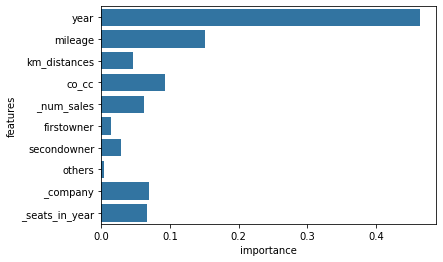

In [1335]:
fp = pd.DataFrame({'importance':reg.feature_importances_, 'features':reg.feature_names_in_})
sns.barplot(data = fp, x = 'importance', y = 'features')

**The more influence of owner variable is on higer selling price , i.e higher selling price is sparse and feature domination also impacts**

**<span style = color:blue >Here we have used standard scaling in above model but if more variation in higer selling prices occurs the model will fail that is the object</span>**